# Data Exploration 

This notebook will take the filtered dataset and perform simple data exploration. A data-driven method to predict power consumption of drones is essentially a supervised learning problem. The input to the model are features such as velocity and acceleration and the output of the model is power. As power is labelled and known data, any model with structured learning techniques (like neural network, regression) could be used.

The goal of data exploration in this notebook:

1. Understand the distribution of variables of the model and the relationship between them
2. Visualize the large dataset (50K+ rows) of all the flight logs in a meaningful way
3. Explore the effect of two variables on power consumption, the wind and payload

In [1]:
### PACKAGES IMPORTS ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.stats import norm

### INCLUDE GRAPHS IN NOTEBOOK AUTOMATICALLY ###
%matplotlib inline 
from IPython.display import display, Latex

## Import data

In [2]:
#load csv file
raw_data = pd.read_csv('C:/Users/nghj7/Desktop/Flight data/fulldata.csv');
#create dataframe
df = pd.DataFrame(raw_data);
print("Shape of dataframe: ", df.shape)

Shape of dataframe:  (54348, 30)


c:\users\nghj7\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
variables = ['battery_power', 
             'v_N','v_E','v_D',
             'a_N','a_E','a_D',
             'angular_x', 'angular_y', 'angular_z',
             'wind_N', 'wind_E']

The `summary_stat` function collects the summary statistics to quantify the variables that would be difficult to read off from the visualization graphs. The data will be grouped by `drone_type`, `flight_mode` and `payload` and will be introduced accordingly.

In [4]:
def summary_stat(input_df, var, group_type, output_df):
    """
    This function collects the mean, standard deviation, max, min
    of a variable from the input dataframe and returns the output dataframe
    """
    output_df.loc[(group_type, 'mean'), var] = input_df[var].mean()
    output_df.loc[(group_type, 'std'), var] = input_df[var].std()
    output_df.loc[(group_type, 'max'), var] = input_df[var].max()
    output_df.loc[(group_type, 'min'), var] = input_df[var].min()
    return output_df

#for drone comparison
multi_index = [np.array(['matrice_100']*4 + ['matrice_600']*4 + ['inspire']*4 + ['mavic']*4),
    np.array(['mean', 'std', 'min', 'max']*4)]
summary1 = pd.DataFrame(index = multi_index, columns = variables)
#for flight mode comparison
multi_index2 = [np.array(['forward']*4 + ['climb']*4 + ['descend']*4 + ['hover']*4),
    np.array(['mean', 'std', 'min', 'max']*4)]
summary2 = pd.DataFrame(index = multi_index2, columns = variables)
#for payload comparison
multi_index3 = [np.array(['0kg']*4 + ['0.25kg']*4 + ['0.5kg']*4 + ['0.75kg']*4),
    np.array(['mean', 'std', 'min', 'max']*4)]
summary3 = pd.DataFrame(index = multi_index3, columns = variables)

## Univariate Analysis: Histogram Plot

The histogram plot is a bar plot of variables to represent the data distribution.  The X-axis is the bin range (discretization of continuous values) while the Y-axis is the frequency/count corresponding to each bin interval. The `histplot` function in seaborn package is used to create the plot. The `kde` argument is set to `True`, which fits a normal distribution to the data. The density estimate allows multiple peaks with mixture of more than one normal distributions.

### Matrice 100 Dataset

The Matrice 100 dataset is collected from 209 test flights. In general, the flight profile starts with climb to predefined  altitude, maintaining a commanded speed along a path and ends with descend to ground. The dataset also includes hover, where the drone is commanded to maintain at a height for the whole test duration. The flight profile will be analyzed further in the later sections.

General observations for Matrice 100:

1. Power (appears normally distributed)
2. Ground acceleration $a_{N,E,D}$ (appears normally distributed with sharp peak)
3. Ground velocity $v_{N,E,D}$ (not normally distributed with multiple distinct peaks)
4. Wind (airspeed) $v_{wind,N/E}$ (appears normally distributed with two peaks)
5. Angular velocity $\omega_{x,y,z}$ (appears normally distributed with sharp peak)

Possible explanations:

- Vertical acceleration $a_{D}$ of the drone occurs during climb and descend, both manuevers opposite in direction and sign convention which is likely to be symmetric about zero.
- Horizontal acceleration $a_{N,E}$ also peaks at zero. This may mean that drone do not require much acceleration in an average flight for control and stability
- Velocity $v_{N,E,D}$ has multiple peaks as the drone is commanded with different ground velocity for the tests.
- Wind velocity $v_{wind,N/E}$ is the air speed of the drone. However, it is affected by wind which is random process in the external environment. Wind velocity will not be normally distributed if the wind is strong in magnitude at a constant direction, such as an area with gust.
- Angular velocity $\omega_{x,y,z}$ is the rate of change of direction of the flight path, which is likely to be zero on average given that the drone flight path is straight and there are not many rotational manuevers.

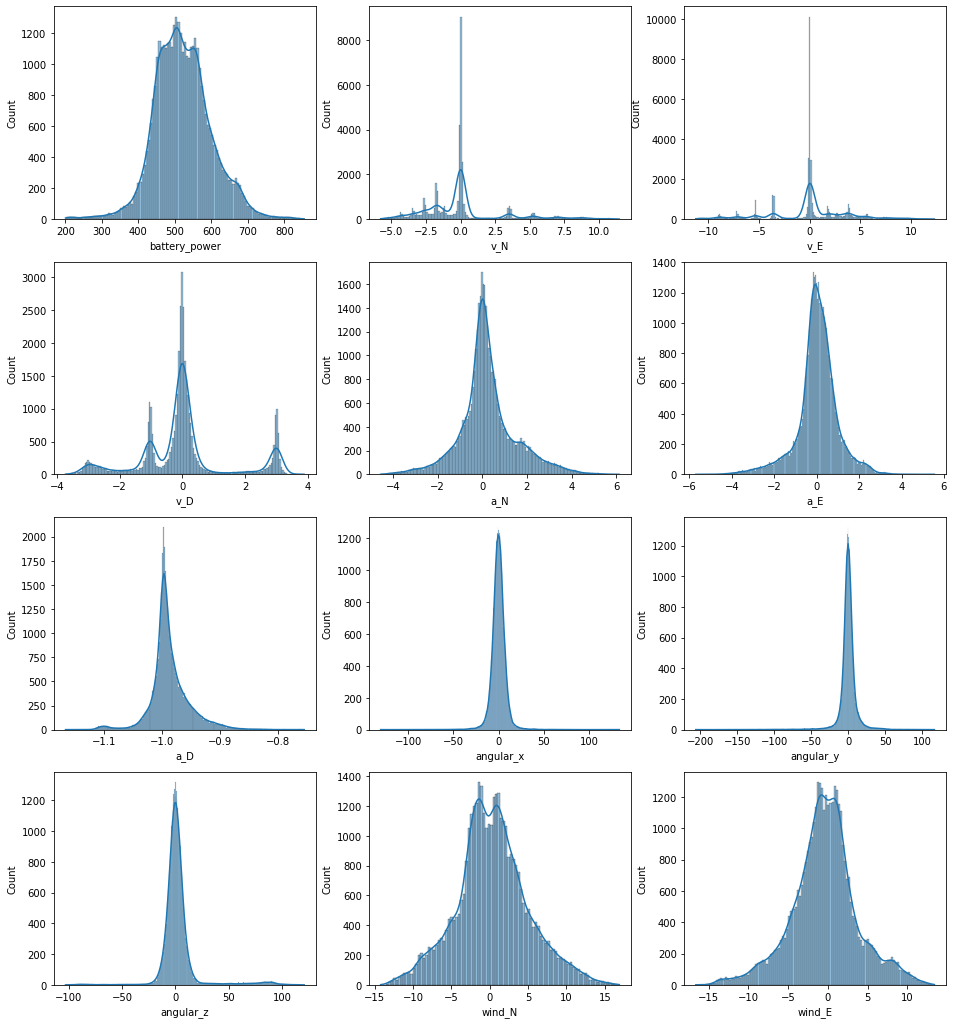

In [5]:
df_plotdata = df[df['drone_type']=='matrice_100']
df_plotdata = df_plotdata[df_plotdata['battery_power'] >= 200]

f,axes = plt.subplots(4,3,  figsize=(16,18))
for var, ax in zip(variables, axes.flatten()):
    summary_stat(df_plotdata, var, 'matrice_100', summary1)
    sb.histplot(data=df_plotdata, x=var, ax=ax, kde=True)

### Matrice 600 Dataset

The Matrice 600 dataset is collected from two test flights.

General observations for Matrice 600:

1. Power (appears normally distributed)
2. Ground acceleration $a_{N,E,D}$ (appears normally distributed with slight skew)
3. Ground velocity $v_{N,E,D}$ (appears normally distributed)
4. Wind (missing data)
5. Angular velocity $\omega_{x,y,z}$ (appears normally distributed with sharp peak)

Possible Explanations:

- The mean velocity $v_{N,E,D}$ is zero and there is no distinct peaks at other values. It may be due to drone travelling at low velocity or following curved paths. The condition is also true if the velocity is not held constant and changes sign rapidly which result in zero mean. There could also be lack of data that shows the peak at other velocity. 

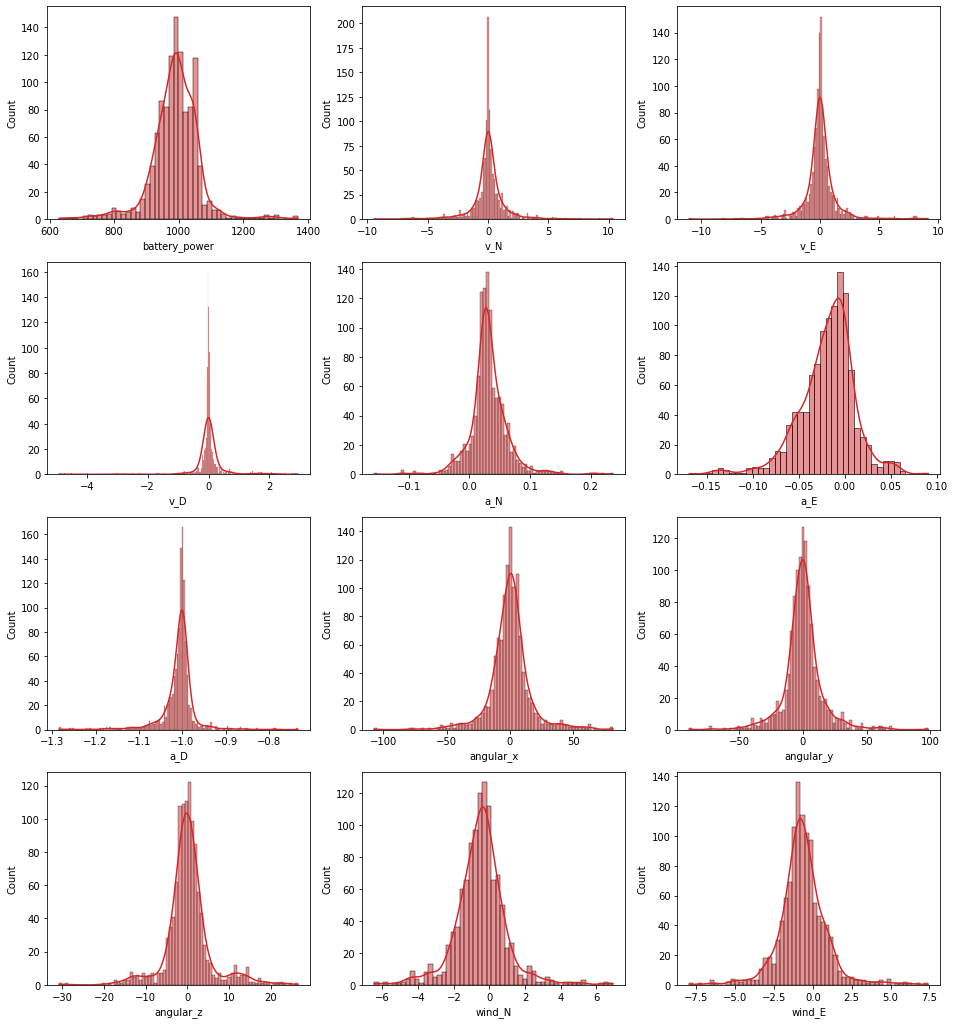

In [6]:
df_plotdata = df.loc[df['drone_type']=='matrice_600']
df_plotdata = df_plotdata[df_plotdata['battery_power'] >= 600]

f,axes = plt.subplots(4,3, figsize=(16,18))
for var, ax in zip(variables, axes.flatten()):
    summary_stat(df_plotdata, var, 'matrice_600', summary1)
    sb.histplot(data=df_plotdata, x=var, ax=ax, kde=True, color ='tab:red')

### Inspire 1 Dataset

The Inspire dataset is collected from two flights only.

General observations for Inspire:

1. Power (appears normally distribute with obvious skew)
2. Ground acceleration $a_{N,E,D}$ (appears normally distributed)
3. Ground velocity $v_{N,E,D}$ (appears normally distributed except for vertical velocity)
4. Wind (missing data)
5. Angular velocity $\omega_{x,y,z}$ (appears normally distributed)

Possible explanations:
- For horizontal velocity $v_{N,E}$ , zero mean velocity may imply that the drone is not maintaining a constant velocity. Same explanation as stated previously
- For vertical velocity $v_{D}$ , distinct peaks show that the flight may have more vertical movements than horizontal movements on average.

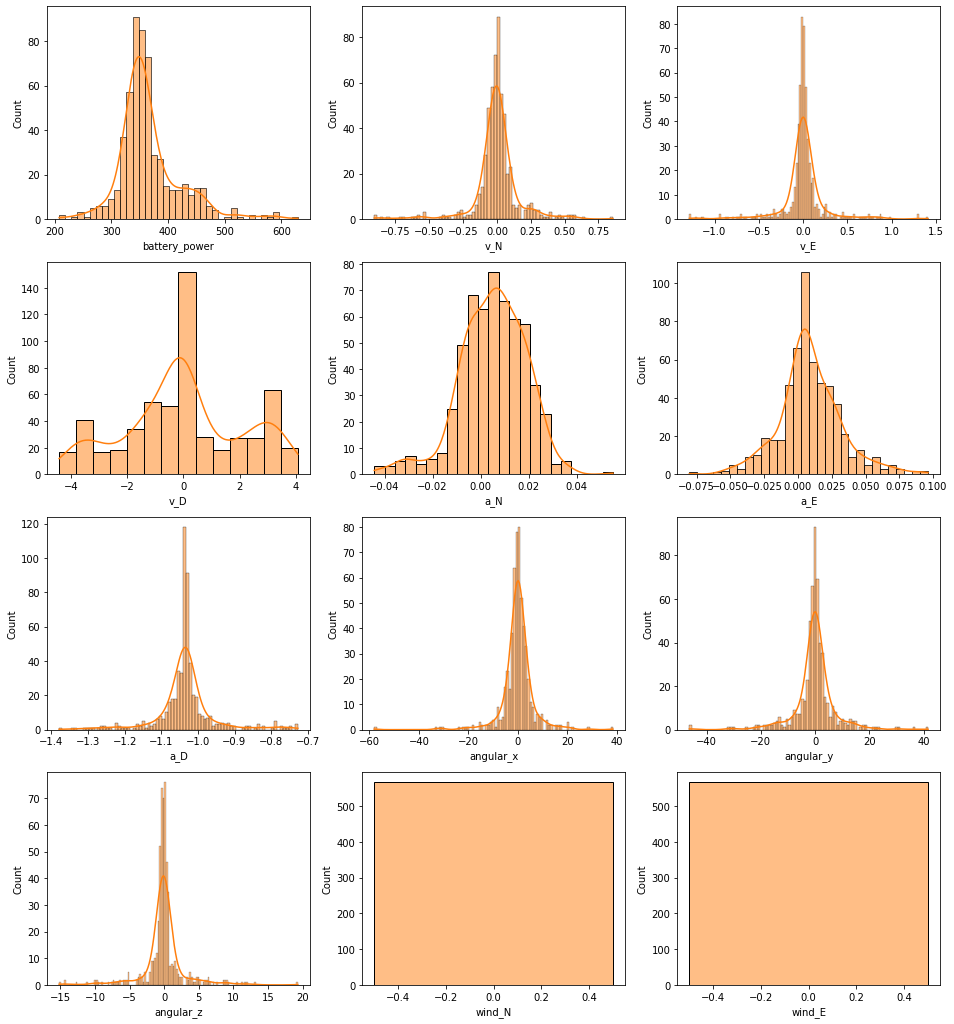

In [7]:
df_plotdata = df.loc[df['drone_type']=='inspire']
df_plotdata = df_plotdata[df_plotdata['battery_power'] >= 200]
    
f,axes = plt.subplots(4,3, figsize=(16,18))
for var, ax in zip(variables, axes.flatten()):
    summary_stat(df_plotdata, var, 'inspire', summary1)
    sb.histplot(data=df_plotdata, x=var, ax=ax, kde=True, color='tab:orange')

### Mavic Pro Dataset

The Mavic dataset is collected from four flights.

General observations for Mavic:

1. Power (appears normally distribute with obvious skew)
2. Ground acceleration $a_{N,E,D}$ (appears normally distributed)
3. Ground velocity $v_{N,E,D}$ (normally distributed with sharp peaks)
4. Wind (airspeed) $v_{wind,N/E}$ (appears normally distributed with two peaks) 
5. Wind magnitude is bounded between $5m/s$ which is lower compared to Matrice 100
6. Angular velocity $\omega_{x,y,z}$ (appears normally distributed)

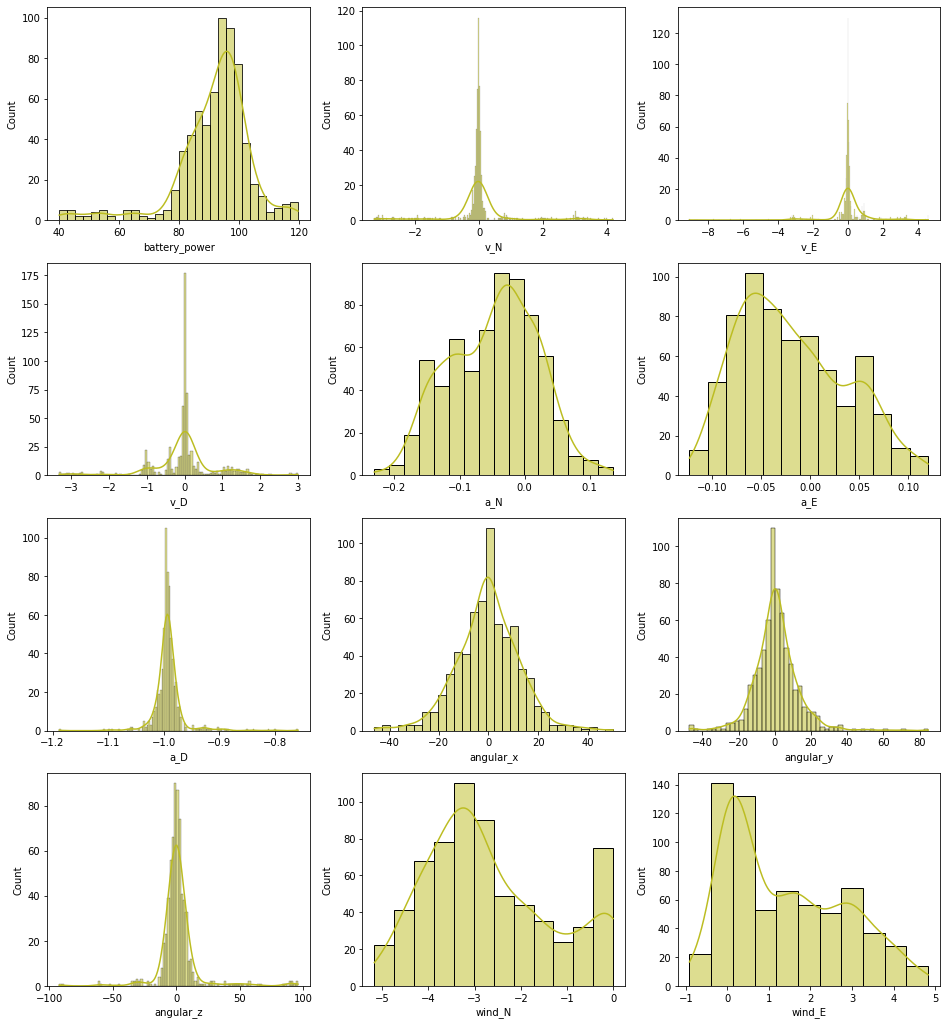

In [8]:
df_plotdata = df.loc[df['drone_type']=='mavic']
df_plotdata = df_plotdata[df_plotdata['battery_power'] >= 40]
    
f,axes = plt.subplots(4,3, figsize=(16,18))
for var, ax in zip(variables, axes.flatten()):
    summary_stat(df_plotdata, var, 'mavic', summary1)
    sb.histplot(data=df_plotdata, x=var, ax=ax, kde=True, color='tab:olive')

## Bivariate Analysis: Scatter Plot

The scatter plot shows the relationship between two variables. For regression problem, Y-axis is the power while X-axis are the input features. Linear relationship between variables can be calculated using correlation coefficient $r_{corr} = \frac{cov(X,Y)}{\sigma_{X}\sigma_{Y}}$ . Only **Matrice 100 dataset** will be used for bivariate analysis as it has most amount of data and the scatter plot of other drones are too sparse for useful visualization.

### Linear Correlation

Power below 200W have been removed for plotting because it signifies the start and end of flight. The resulting scatter plot is a combination of many flight tests.

In [9]:
variables = ['battery_power', 
             'v_N','v_E','v_D',
             'a_N','a_E','a_D',
             'angular_x', 'angular_y', 'angular_z',
             'wind_N', 'wind_E']

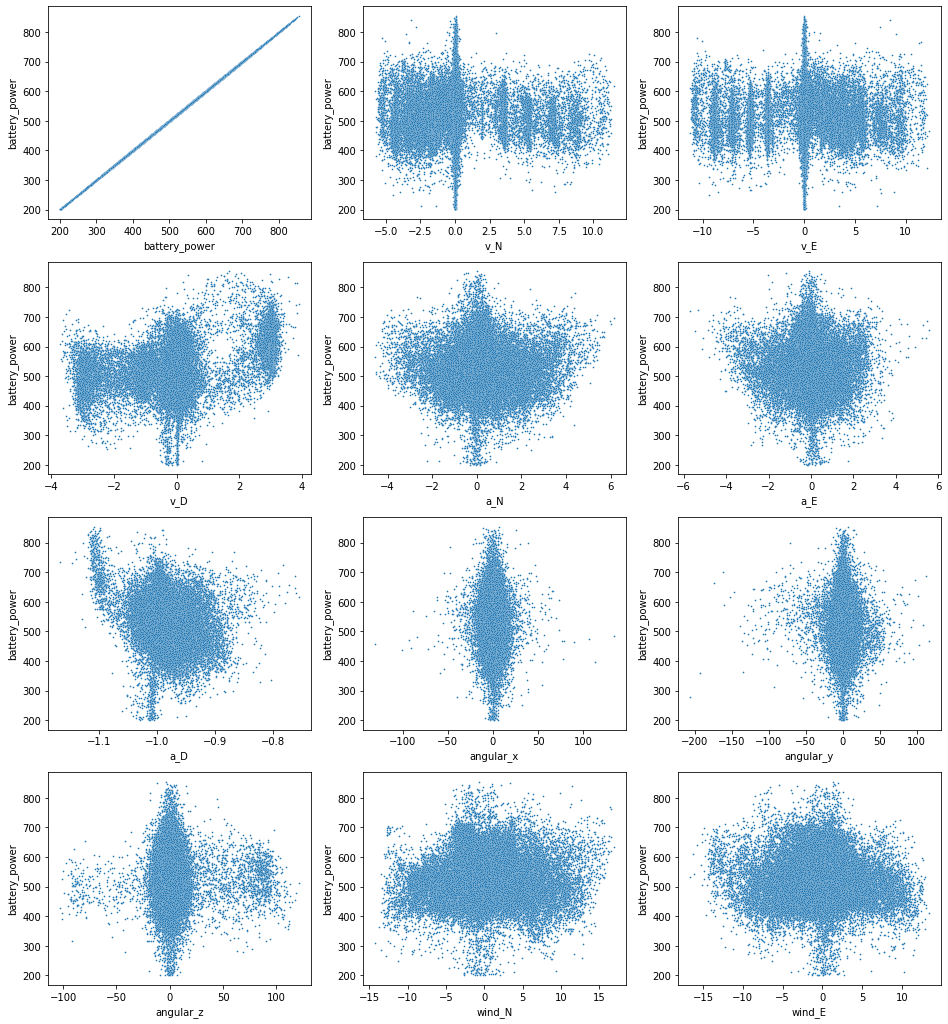

In [10]:
f,axes = plt.subplots(4,3, figsize=(16,18))
df_plotdata = df.loc[df['drone_type']=='matrice_100']
df_plotdata = df_plotdata[df_plotdata['battery_power'] >= 200]

for var, ax in zip(variables, axes.flatten()):
    sb.scatterplot(data=df_plotdata, x=var, y=variables[0], ax=ax, s=3.0)

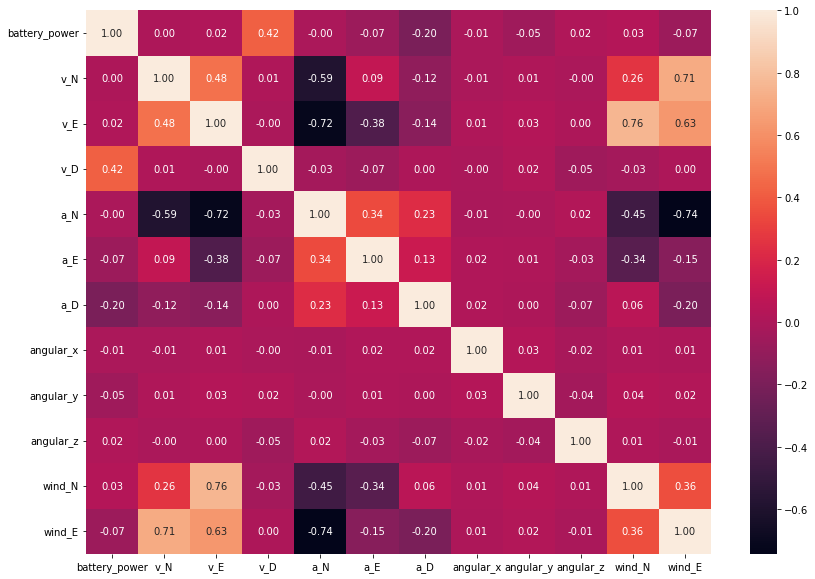

In [11]:
#calculate correlation
df_matrice100 = df.loc[df['drone_type']=='matrice_100'].copy()
df_matrice100 = df_matrice100.loc[df_matrice100['battery_power'] >= 200]
df_joint = df_matrice100[variables].corr()
plt.figure(figsize=(14,10));
sb.heatmap(df_joint, annot = True, fmt='.2f');

General observations with possible explanation:

1. Horizontal velocity $v_{N,E}$ and acceleration $a_{N,E}$ has weak linear correlation to power. One possible reason is that an increase in acceleration forward or backward can be achieved without higher power consumption through differential rotation of the propeller. 
2. Vertical velocity $v_{D}$ and acceleration $a_{D}$ is negatively correlated to power with a magnitude of -0.39 and -0.25 respectively. This is expected as an increase in acceleration upwards (magnitude becomes more negative) will lead to higher power consumption
3. Wind (airspeed) $v_{wind,N/E}$ has weak linear correlation to power. One possible reason is that drag power is a non-linear function of wind velocity in $P_{drag} \propto v^{3}$ . Moreover, the power measured is the sum of all component power required (e.g. avionics, drag, motor) by the drone and is likely to be a non-linear function.
4. Wind (airspeed) $v_{wind,N/E}$ has strong linear correlation to ground velocity $v_{N,E}$. This can be seen from the velocity triangle relationship $\vec{v_{ground,N}} = \vec{v_{g/w,N}} + \vec{v_{wind,N}}$

## Flight Analysis of Matrice 100

Information about the flight can be understood through analyzing the altitude-time graph. The gradient of the altitude-time is the instantaneous velocity of the maneuver. From time graph, the flight modes for flight `1` can be easily deduced:

1. From $0 \leq t \lt 25 sec$ , the drone is in takeoff climb 
2. From $25 \leq t \leq 150 sec$ , the drone is in forward flight at constant altitude
3. From  $150 \lt t \leq 200 sec$ , drone descends back to the ground

### Altitude Time Graph

matrice_100 flight 1 alt mean: 285.65
matrice_100 flight 1 alt std: 9.51
matrice_100 flight 208 alt mean: 299.51
matrice_100 flight 208 alt std: 32.94


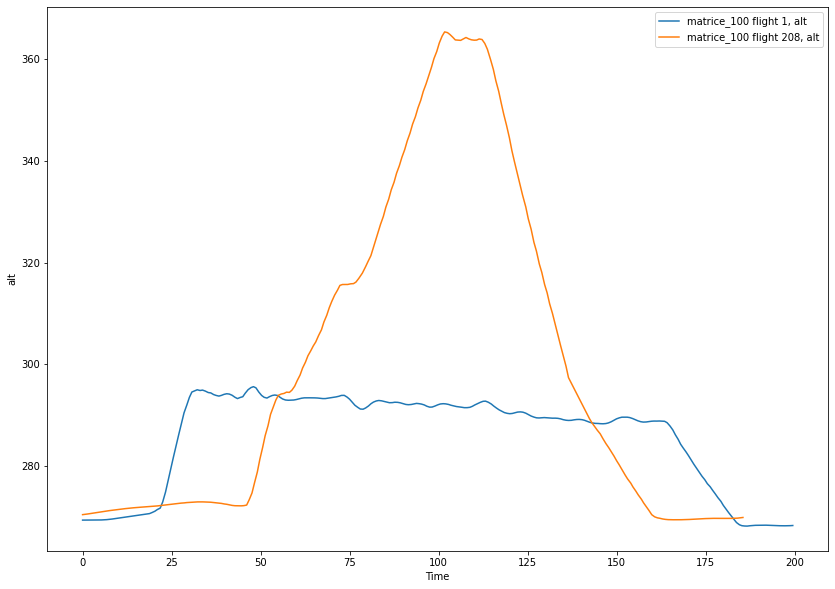

In [12]:
def plotflight(dataframe, flightno, param, min_t=0, max_t=-1):
    """
    This function plots parameter against time for given flight number.
    """
    for flno in flightno:
        plotdata = dataframe.loc[dataframe['flight'] == flno].copy()
        t = plotdata['time'] - float(plotdata['time'].head(n=1))
        for var in param:
            name = plotdata['drone_type'].iloc[0]
            y = plotdata[var]
            plt.plot(t[min_t:max_t], y[min_t:max_t], label =  name + ' flight ' + str(flno) + ', ' + var)
            plt.ylabel(str(var))
            print(f'{name} flight {flno} {var} mean: {float(y.mean()):.2f}')
            print(f'{name} flight {flno} {var} std: {float(y.std()):.2f}')
        plt.xlabel('Time')
    plt.legend()
    
    
plt.figure(figsize=(14,10));    
plotflight(df, [1,208], ['alt'])

### Flight Mode Separation

As evident from the altitude-time graph, flight `208` performs multiple climb before reaching the maixmum altitude at `360m`, which simulates real flying conditions for delivery drones. Separation of flight modes can be done by computing the slope of the graph. $d_{alt} = (alt_{t+5}-alt_{t}) \div 5$, where $t+5$ is the time step difference taken for a smooth slope. The separation is then done using the following rules:

1. Forward flight would correspond to $-0.5 \lt d_{alt} \lt 0.5$ where the change in altitude tolerance is taken to be smaller than $0.5 meters$
2. Climb flight would correspond to  $d_{alt} \gt 0.5$ with positive slope for altitude
3. Descend flight would correspond to  $d_{alt} \lt -0.5$ with negative slope for altitude
4. Hover flight is labelled as `H` in route

Note that the separation will not be completely accurate because there is variance in the altitude-time graph such that a tolerance range must be defined.

In [13]:
label_dict = {}
def label_flight_mode(dataframe, dictionary=label_dict):
    """
    This function takes each row of the dataframe as input and returns 
    the mode (string) corresponding to the tuple (t_i, t_f) where it indicates
    the time interval for forward flight. The separation using 5 meters from
    the maximum altitude is used.
    """
    index = dataframe['flight']
    if dataframe['route'] == 'H':
        return 'hover'
    elif dataframe['diff_alt'] > 0.5:
        return 'climb'
    elif dataframe['diff_alt'] < -0.5: 
        return 'descend'
    else:
        return 'forward'
    
df_matrice100 = df.loc[df['drone_type']=='matrice_100'].copy()
flight_list = np.unique(list(df_matrice100.flight))

for flno in flight_list:
    #filter by flight number
    temp = df.query(('flight == ' + str(flno)))
    diff_alt = temp.alt.diff(periods=5)
    df_matrice100.loc[temp.index, 'diff_alt'] = diff_alt
    
#apply label to each row of dataframe   
df_matrice100['mode'] = df_matrice100.apply(label_flight_mode, axis = 1)

### Flight Mode Histogram Plot

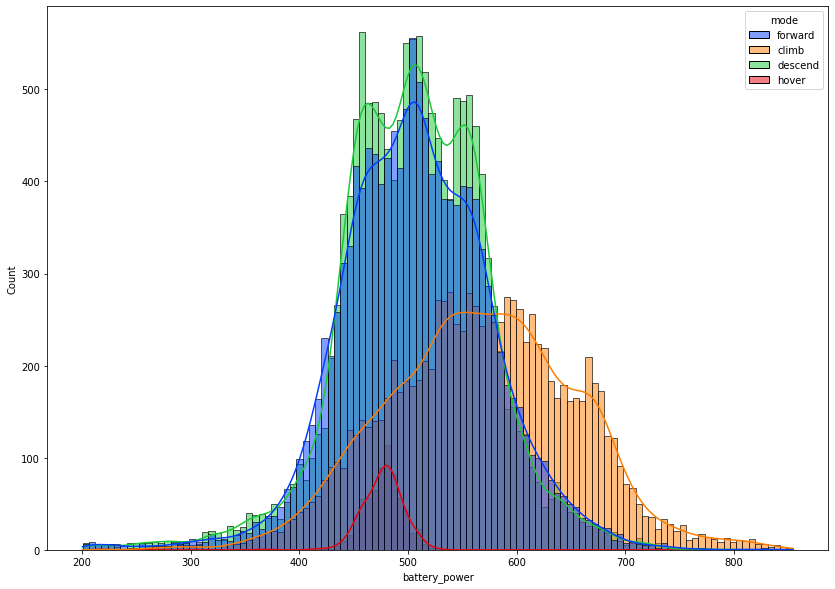

In [14]:
df_plotdata = df_matrice100[df_matrice100['battery_power'] >= 200].copy()

plt.figure(figsize=(14,10));
sb.histplot(data=df_plotdata, hue='mode', x=variables[0], kde=True, palette='bright');

General observations of histogram plot:

1. **Forward** and **Hover** flight appears to be normally distributed. **Descend** and **Climb** flight have multiple peaks. The multiple peaks may be caused by differences in payload which will be analyzed later.
2. **Climb** flight has highest mean power. This is expected due to higher power required to overcome gravitational forces.
3. **Hover** flight has the lowest mean power. It is counter intuitive when comparing with forward flight because there is ideally no drag to oppose thrust. Two possible effect that leads to lower mean power could be due to ground effect or low wind condition. There is insufficient data to compare variance for **Hover** mode
4. **Forward** flight has the second largest variance compared to other modes. This could be due to wind condition which will be analyzed later.

### Flight Mode Scatter Plot

A custom function to draw the scatter plot was defined instead of using default seaborn package to overwrite behavior of color coding for easy visualization. Color coding is as follows: **Descend** (blue), **Climb** (green), **Hover** (red) and **Forward** (black).

In [15]:
#color coding
cdict = {'descend': 'tab:blue', 'climb': 'tab:green', 'hover': 'tab:red','forward': 'black'}

def flight_scatter(dataframe, x_label, y_label, ax):
    """
    This function takes an input dataframe and plots the scatter
    plot for two parameters of a particular flight. 
    """
    x = np.array(dataframe[x_label])
    y = np.array(dataframe[y_label])
    all_modes = np.array(dataframe['mode'])
    for sample_mode in np.unique(all_modes):
        ind = np.where(all_modes==sample_mode)
        ax.scatter(x[ind], y[ind], c=cdict[sample_mode], label= sample_mode, s=3)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()

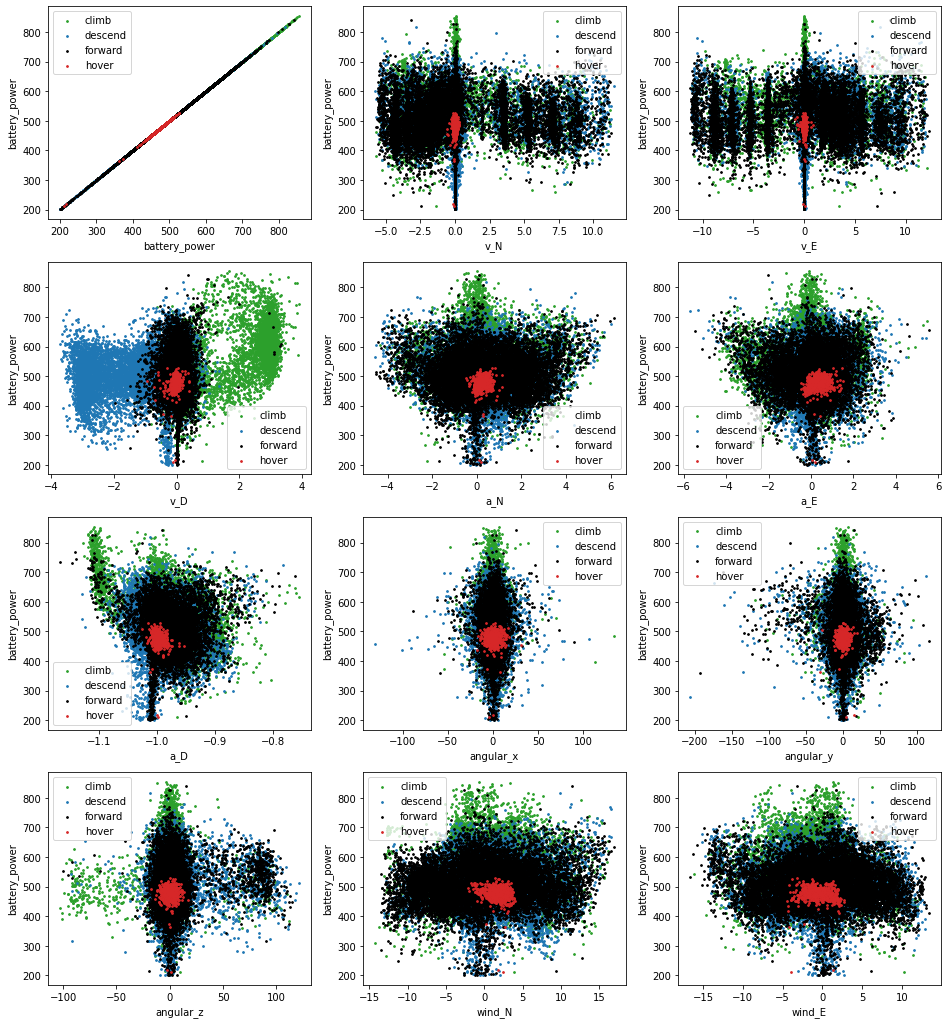

In [16]:
f,axes = plt.subplots(4,3, figsize=(16,18))
for var, ax in zip(variables, axes.flatten()):
    flight_scatter(df_plotdata, x_label=var, y_label=variables[0], ax=ax)

General observations of scatter plot:

1. Power during **Climb** is higher than power during **Descend** as shown by the green dots above blue dots. Same explanation as mentioned before.
2. **Hover** concentrates around the center of the scatter plot which is also reasonable since all quantity will be ideally zero in stationary hover.
3. The magnitude of wind experienced during **Forward** flight is $-15 \leq v_{wind, N/E} \leq 15 m/s$ , relatively higher than other modes. Therefore, wind could be the underlying factor for variance in power during **Forward** flights.


### Summary of Statistics (by Flight Mode)

In [17]:
for sample_mode in ['forward','climb','hover','descend']:
    for var in variables:
        temp = df_plotdata.loc[df_plotdata['mode']==sample_mode].copy()
        summary_stat(temp, var, sample_mode, summary2)
        
display(Latex(summary2.loc[:, variables[:6]].to_latex()))

<IPython.core.display.Latex object>

In [18]:
display(Latex(summary2.loc[:, variables[6:]].to_latex()))

<IPython.core.display.Latex object>

## Payload Analysis of Matrice 100

Payload is an operational requirement for all delivery drones. Intuitively, higher payload requires more energy to do work in moving the drone from one point to another. 

The Matrice 100 dataset was tested with four different payloads of $0.0, 0.25, 0.5, 0.75kg$ . The scatter plot of payload against power was omitted previously because the plot shows four vertical lines through each payload value. The scatter plot will only be meaningful if more payload values were tested or if intervals between payload is small (e.g. $0.1, 0.2kg$ ..). A different visualization will be given to explore the relationship between power and payload here.

### Payload Histogram Plot

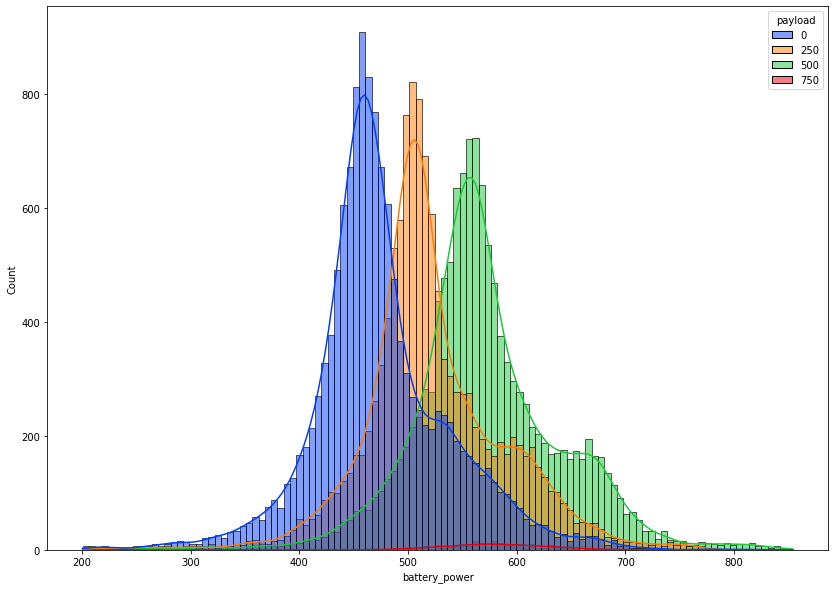

In [19]:
df_matrice100 = df.loc[df['drone_type']=='matrice_100'].copy()
df_plotdata = df_matrice100[df_matrice100['battery_power'] >= 200].copy()

plt.figure(figsize=(14,10));
sb.histplot(data=df_plotdata, hue='payload', x=variables[0], kde=True, palette='bright');

General observation of histogram plot:

1. The effect of increasing payload is an increase in mean power as the distribution shifts to the right. The variance remains similar across different payloads.
2. There is insufficient data for $750g$ payload (red line) to compare its distribution.

One limitation of insufficient payload data is that the machine learning model may give less weight to sparse data during inference. Specifically, as most machine learning model uses gradient descend method, sparse data provide too little information about the gradient function. However, it is still desirable to include payload (even if test range is discrete and sparse) to train the machine learning model as a change in payload will lead to a covariate shift in power.

### Payload Scatter Plot

A custom function to draw the scatter plot was defined instead of using default seaborn package to overwrite behavior of color coding for easy visualization. Color coding is as follows: $0.0kg$ (blue), $0.25kg$ (green), $0.5kg$ (red) and $0.75kg$ (black).

In [20]:
#color coding
cdict2 = {0: 'tab:blue', 250: 'tab:green', 500: 'tab:red', 750: 'black'}

def payload_scatter(dataframe, x_label, y_label, ax):
    """
    This function takes an input dataframe and plots the scatter
    plot for two parameters of a particular flight. 
    """
    x = np.array(dataframe[x_label])
    y = np.array(dataframe[y_label])
    all_payload = np.array(dataframe['payload'])
    for sample_payload in np.unique(all_payload):
        ind = np.where(all_payload==sample_payload)
        ax.scatter(x[ind], y[ind], c=cdict2[sample_payload], marker='x', label= str(sample_payload/1000)+'kg', s=3)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()

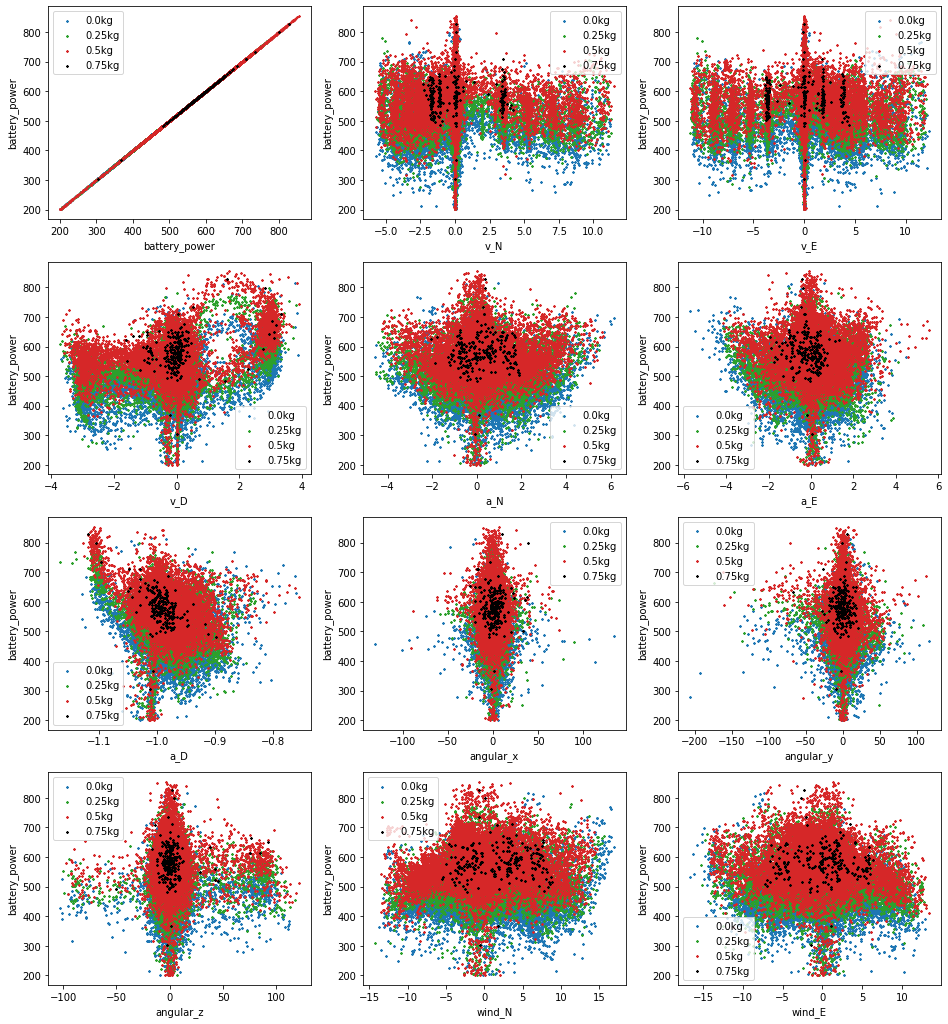

In [21]:
f,axes = plt.subplots(4,3, figsize=(16,18))
for var, ax in zip(variables, axes.flatten()):
    payload_scatter(df_plotdata, x_label=var, y_label=variables[0], ax=ax)

General observations of scatter plot:

1. The effect of increasing payload can be seen in the scatter plot. Increasing payload form distinct layers of points that shifts towards higher power. 

### Mean Power Estimation

Both histogram and scatter plots showed the covariate shift of power with different payload. This provides a motivation to estimate mean power for different payload by looking at the power distribution. It could potentially be used to interpolate or extrapolate power at other payloads even with missing or insufficient data. For instance, by looking at the mean power $\mu$  from payload of $0kg$ and $0.50kg$, the mean power of $0.750kg$ could be predicted. 

A few assumptions must be made for a rough estimation. Firstly, power is an independent, identically distributed random variable. Secondly, the estimated distribution is normal. Lastly, the predicted power for that payload value will have similar flight condition, velocity and acceleration value range to be valid. The value range are given in the summary of statistics below.

Method:

- Fit $P_{m,payload}$ data with $N(\mu, \sigma^{2})=\frac{1}{\sigma\sqrt{2}} e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^{2}}$ 
- Perform linear regression of $\mu = m*m_{payload}+b$ where $m$ is slope and $b$ is intercept
- Assume $\sigma$ is independent of payload $m_{payload}$. Also assume $\sigma \approx \frac{\sigma_{0kg}+\sigma_{0.25kg}+\sigma_{0.5kg}+\sigma_{0.75kg}}{4}$ 

Mean Power Regression Slope = 148.01, Intercept = 482.27
Std Power = 64.04


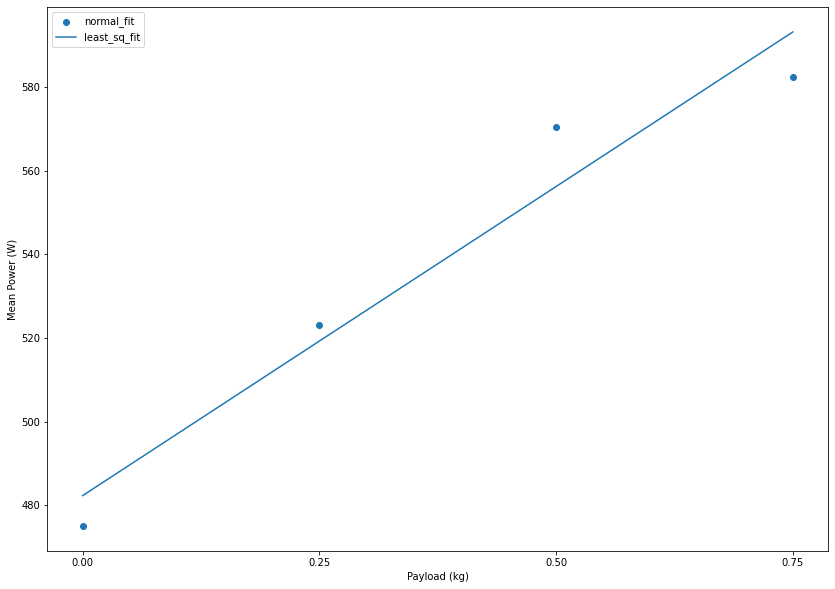

In [22]:
X = [0, 0.25, 0.5, 0.75]
MU = [0]*4
STD = [0]*4

#normal distribution fit
for i,payload in enumerate(X):
    temp = df_plotdata.loc[df_plotdata['payload']==payload*1000].copy()
    MU[i], STD[i] = norm.fit(temp.battery_power)
    for var in variables:
        #for summary
        summary_stat(temp, var, str(payload)+'kg', summary3)

#least square fit
mean_coef = np.polyfit(X, MU, deg=1)
std_coef = np.mean(STD)
print(f'Mean Power Regression Slope = {mean_coef[0]:.2f}, Intercept = {mean_coef[1]:.2f}')
print(f'Std Power = {std_coef:.2f}')

#plot best fit line
plt.figure(figsize=(14,10))
plt.scatter(X,MU, label='normal_fit')
plt.plot(X,[mean_coef[0]*x + mean_coef[1] for x in X], label='least_sq_fit')
plt.ylabel('Mean Power (W)');
plt.xlabel('Payload (kg)');
plt.xticks(X)
plt.legend();

### Generating Data From Distributions

If the assumptions above are valid, one could generate new data using two methods. Firstly, transform old data by mapping to the new distribution. Secondly, draw random sample from the estimated distribution. However, there is no guarantee that the generated data is accurate and obtainable until real flight tests are conducted.

Method 1: 

- Given $X \sim N(\mu_{0.5kg}, \sigma_{0.5kg}^{2})$, transform to $Y \sim N(\mu_{0.75kg}, \sigma_{0.75kg}^{2})$
- Use property $Var(aX)=a^2Var(X)$ and $E(aX+b) = a*E(X)+b$
- $Y = aX + b$ where constants $a=\frac{\mu_{0.75kg}}{\mu_{0.5kg}}$ and $b=\mu_{0.75kg}-a*\mu_{0.5kg}$

Method 2:

- Given $Y \sim N(\mu_{1kg}, \sigma_{1kg}^{2})$
- Sample $y \sim Y$ for N times randomly  

Estimated Mean Power at 0.75kg = 596.56, Estimated Std Power at 0.75kg = 63.45
Mean Power Error (estimated - actual) for 0.75kg = 14.10
Estimated Mean Power at 1kg = 630.28, Estimated Std Power at 1kg = 64.04


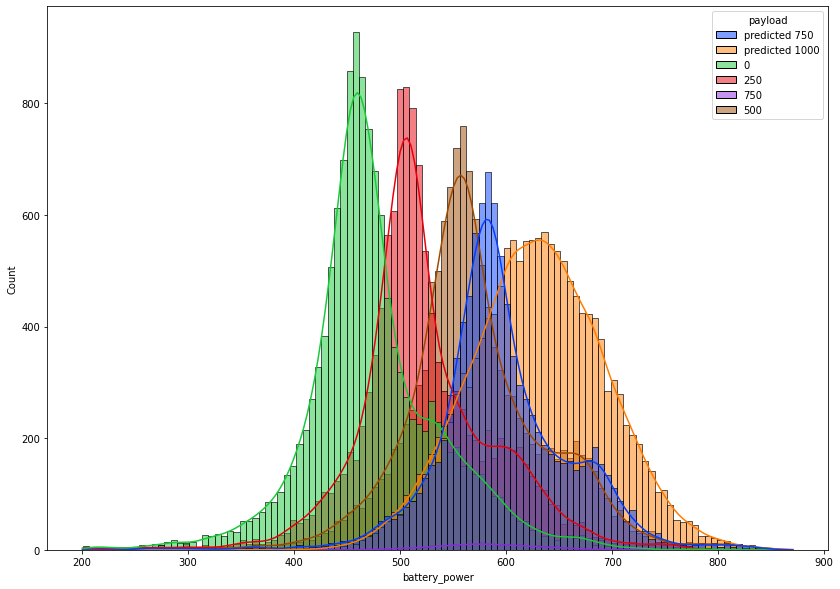

In [23]:
#generate data for 0.75kg using data from 0.5kg (METHOD 1)
mean_750 = mean_coef[0]*0.75 + mean_coef[1]
var_750 = std_coef
mean_500 = MU[2]
var_500 = STD[2]
a = var_750 / var_500
b = mean_750 - a*mean_500
temp = df_plotdata.loc[df_plotdata['payload']==0.5 * 1000].copy()
power_500 = temp.battery_power[:10000]
power_750 = list(a*power_500 + b)
print(f'Estimated Mean Power at 0.75kg = {np.mean(power_750):.2f}, Estimated Std Power at 0.75kg = {np.std(power_750):.2f}')
print(f'Mean Power Error (estimated - actual) for 0.75kg = {np.mean(power_750)-MU[3]:.2f}')

#generate (hypothetical) data for 1kg payload (METHOD 2)
mean_1000 = mean_coef[0]*1 + mean_coef[1]
var_1000 = std_coef
power_1000 = list(norm.rvs(loc=mean_1000, scale=var_1000, size = 15000))
print(f'Estimated Mean Power at 1kg = {mean_1000:.2f}, Estimated Std Power at 1kg = {var_1000:.2f}')

#append to dataframe
list1 = power_750 + power_1000
list2 = ['predicted 750'] * len(power_750) + ['predicted 1000'] * len(power_1000)
df_newdata = pd.DataFrame({'battery_power':list1, 'payload':list2})
df_plotdata2 = pd.concat([df_newdata, df_plotdata], ignore_index=True)

#plot histogram
plt.figure(figsize=(14,10));
sb.histplot(data=df_plotdata2, hue='payload', x=variables[0], kde=True, palette='bright');

### Summary of Statistics (by Payload)

In [24]:
display(Latex(summary3.loc[:, variables[:6]].to_latex()))

<IPython.core.display.Latex object>

In [25]:
display(Latex(summary3.loc[:, variables[6:]].to_latex()))

<IPython.core.display.Latex object>

## Wind Analysis of Matrice 100 and Mavic Pro

Wind is an environmental factor that cannot be controlled during delivery operation. Wind affects the power consumption and acts as disturbance to the control and stability of drone. In theory, **head wind** decreases the airspeed of the drone and more thrust may be required to overcome the resistance. **Tail wind** increases the airspeed of the drone and the thrust required would be reduced.
 
In the dataset, only matrice 100 and mavic have wind data. The method of collecting the wind data is different. For matrice 100, an external anemometer sensor collects the wind data directly. For mavic, the wind data is calculated indirectly using data from IMU and GPS through dynamic state equations. 

Both methods are susceptible to sensor measurement error. For the anemometer, drone movement may induce unsteady airflow and the disturbed airflow could result in inaccurate readings. The sensors from IMU and GPS also have associated errors (drift, noise) that may affect the accuracy of airspeed. To simplify the analysis of wind, it is assumed that such errors are negligible.

### Effect of Headwind and Tailwind
The effect of wind on power was investigated. Strictly speaking, determining whether the drone is experiencing **headwind** and **tailwind** requires knowing the heading direction of the drone. Analyzing the wind direction is further complicated by the fact that a quadcopter has up to six degrees of freedom and coupled maneuvers (roll + pitch) are possible. For simplicity, only the ground velocity and wind along North will be considered. The following diagram shows the sign convention of a **headwind** and **tailwind** through the velocity vector:

![Wind](Part%201%20-%20Wind%20Convention.png)

Head Wind Mean Power = 576.84, Tail Wind Mean Power = 565.61
Head Wind Std Power = 72.94, Tail Wind Std Power = 68.23


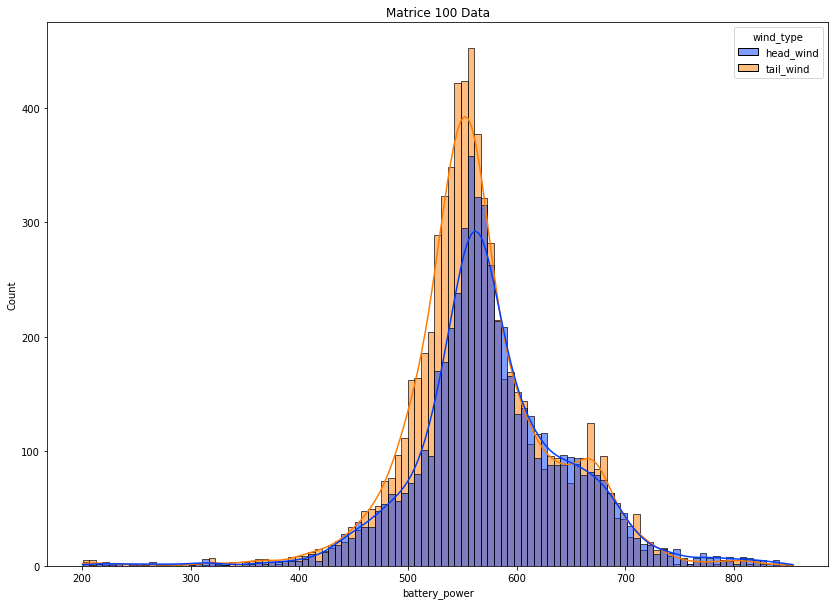

In [26]:
def label_wind(dataframe):
    if (dataframe['v_N'] > 0): #ground speed
        if dataframe['wind_N'] < 0:
            return 'head_wind'
        elif dataframe['wind_N'] > 0:
            return 'tail_wind'
    elif dataframe['v_N'] < 0: #ground speed
        if dataframe['wind_N'] > 0 :
            return 'head_wind'
        elif dataframe['wind_N'] < 0:
            return 'tail_wind'
    
df_matrice100 = df.loc[df['drone_type']=='matrice_100'].copy()
df_plotdata = df_matrice100[df_matrice100['battery_power'] >= 200].copy()
df_plotdata = df_plotdata[df_plotdata['payload'] == 500].copy()
df_plotdata['wind_type'] = df_plotdata.apply(label_wind, axis = 1)

plt.figure(figsize=(14,10));
sb.histplot(data=df_plotdata, hue='wind_type', x=variables[0], kde=True, palette='bright');
plt.title('Matrice 100 Data');
mean1 = df_plotdata[df_plotdata['wind_type'] == 'head_wind'].battery_power.mean()
mean2 = df_plotdata[df_plotdata['wind_type'] == 'tail_wind'].battery_power.mean()
std1 = df_plotdata[df_plotdata['wind_type'] == 'head_wind'].battery_power.std()
std2 = df_plotdata[df_plotdata['wind_type'] == 'tail_wind'].battery_power.std()
print(f'Head Wind Mean Power = {mean1:.2f}, Tail Wind Mean Power = {mean2:.2f}')
print(f'Head Wind Std Power = {std1:.2f}, Tail Wind Std Power = {std2:.2f}')

Head Wind Mean Power = 995.28, Tail Wind Mean Power = 985.78
Head Wind Std Power = 87.67, Tail Wind Std Power = 63.52


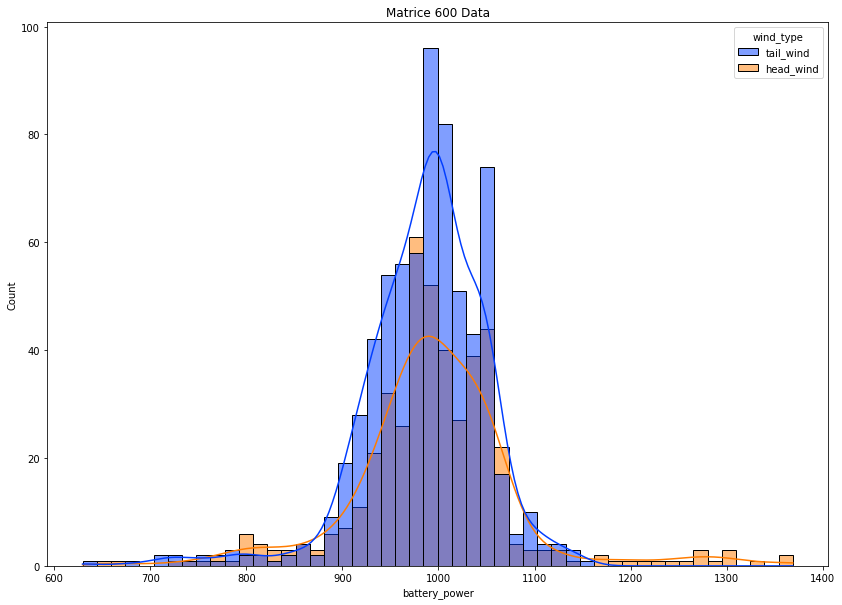

In [27]:
df_matrice600 = df.loc[df['drone_type']=='matrice_600'].copy()
df_plotdata = df_matrice600[df_matrice600['battery_power'] >= 600].copy()
df_plotdata['wind_type'] = df_plotdata.apply(label_wind, axis = 1)

plt.figure(figsize=(14,10));
sb.histplot(data=df_plotdata, hue='wind_type', x=variables[0], kde=True, palette='bright');
plt.title('Matrice 600 Data');
mean1 = df_plotdata[df_plotdata['wind_type'] == 'head_wind'].battery_power.mean()
mean2 = df_plotdata[df_plotdata['wind_type'] == 'tail_wind'].battery_power.mean()
std1 = df_plotdata[df_plotdata['wind_type'] == 'head_wind'].battery_power.std()
std2 = df_plotdata[df_plotdata['wind_type'] == 'tail_wind'].battery_power.std()
print(f'Head Wind Mean Power = {mean1:.2f}, Tail Wind Mean Power = {mean2:.2f}')
print(f'Head Wind Std Power = {std1:.2f}, Tail Wind Std Power = {std2:.2f}')

Head Wind Mean Power = 91.60, Tail Wind Mean Power = 92.31
Head Wind Std Power = 11.12, Tail Wind Std Power = 12.57


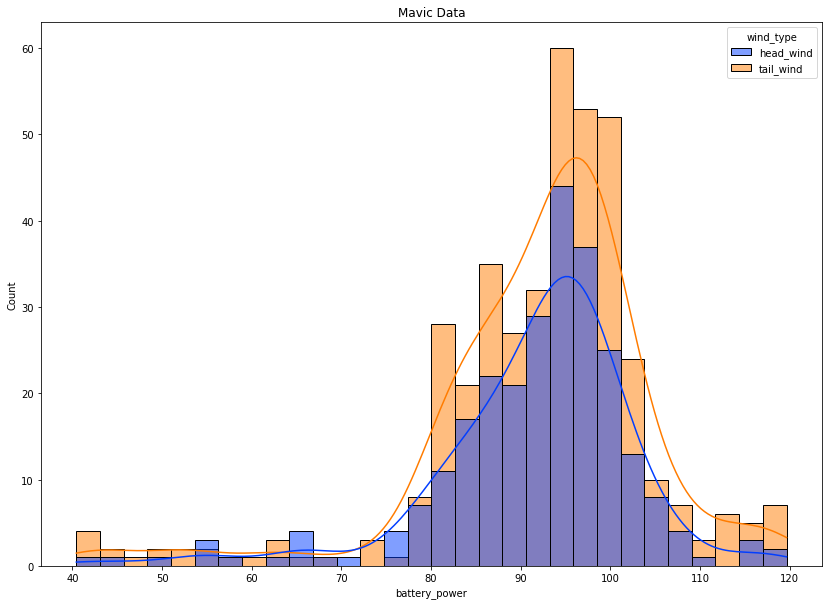

In [28]:
df_mavic = df.loc[df['drone_type']=='mavic'].copy()
df_plotdata = df_mavic[df_mavic['battery_power'] >= 40].copy()
df_plotdata['wind_type'] = df_plotdata.apply(label_wind, axis = 1)

plt.figure(figsize=(14,10));
sb.histplot(data=df_plotdata, hue='wind_type', x=variables[0], kde=True, palette='bright');
plt.title('Mavic Data');
mean1 = df_plotdata[df_plotdata['wind_type'] == 'head_wind'].battery_power.mean()
mean2 = df_plotdata[df_plotdata['wind_type'] == 'tail_wind'].battery_power.mean()
std1 = df_plotdata[df_plotdata['wind_type'] == 'head_wind'].battery_power.std()
std2 = df_plotdata[df_plotdata['wind_type'] == 'tail_wind'].battery_power.std()
print(f'Head Wind Mean Power = {mean1:.2f}, Tail Wind Mean Power = {mean2:.2f}')
print(f'Head Wind Std Power = {std1:.2f}, Tail Wind Std Power = {std2:.2f}')

General observations from Histogram plot:

1. For Matrice 100, the drone in **head wind** have a higher mean power than **tail wind** which is consistent with theory. However, this difference is not as large as varying the payload of the drone. 
2. For Mavic, the difference of mean power between **head wind** and **tail wind** is small. More data may be required.
3. It is inconclusive whether **head wind** and **tail wind** will have a significant impact on the power of the drone just by analyzing the histogram. The probability of **head wind** or **tail wind** occuring is random and both events could occur multiple times throughout a flight. The most probable evidence would be compare between individual flights with calm and extreme wind.

## Cross Dataset Analysis: Box Plot

The box plot shows the distribution of data through the interquartile range. The distribution of each features for different drone type is analyzed. The Y-axis represents the drone type and X-axis shows the feature value. 

To read the box plot: 

1. Shaded box shows the interquartile range (IQR). The values are ordered and sorted in ascending value. Then, the IQR is equal to $Q_{3}-Q_{1}$ or the 25th percentile subtracted from the 75th percentile value. IQR is calculated using the median.
2. Lines at the two extreme ends (whiskers) shows the minimum $Q_{1}-1.5\times IQR$ and maximum $Q_{3}+1.5\times IQR$ value 
3. Point outside the box and whiskers are considered as outliers of the data

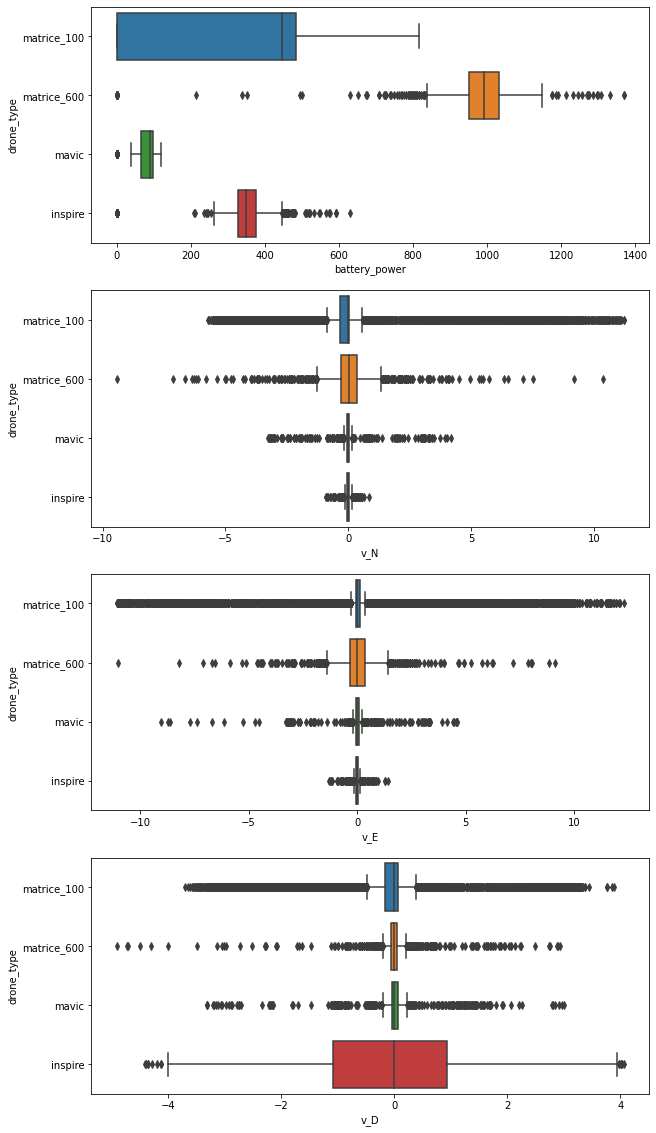

In [29]:
variables = ['battery_power', 
             'v_N','v_E','v_D',
             'a_N','a_E','a_D', 'wind_N', 'wind_E']
df_plotdata = df.loc[df['payload']==0].copy()
df_plotdata = df_plotdata.loc[:,variables+['drone_type']]

f,axes = plt.subplots(4,1, figsize=(10,20))
for var, ax in zip(variables[:4], axes.flatten()):
    sb.boxplot(x=var, y='drone_type', data=df_plotdata, ax=ax)

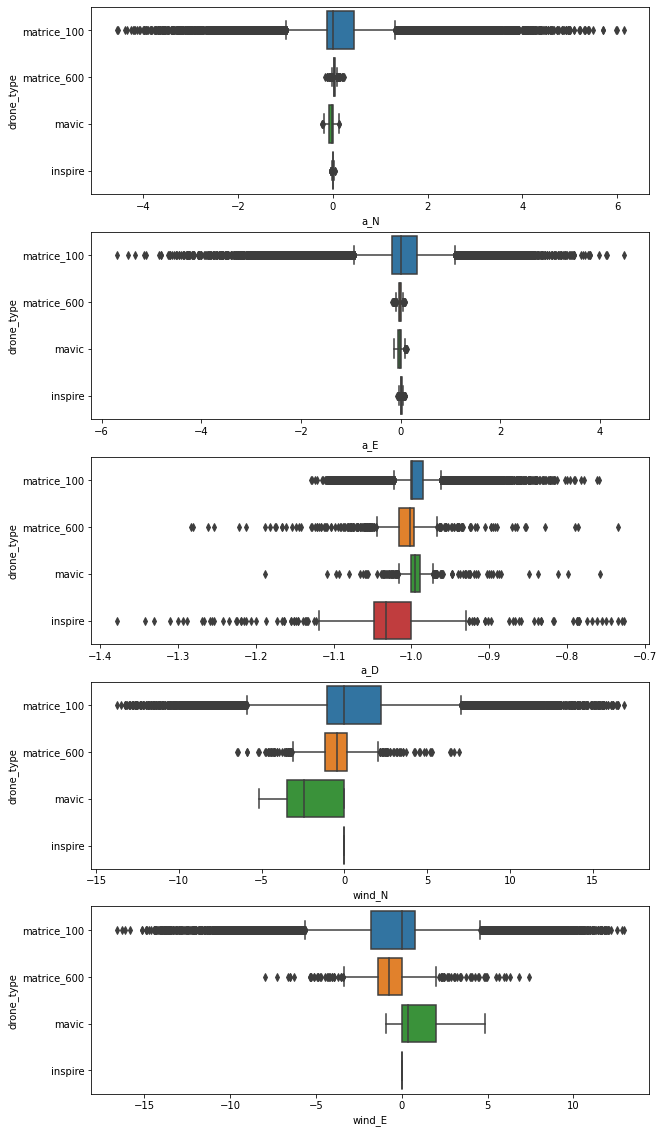

In [30]:
f,axes = plt.subplots(5,1, figsize=(10,20))
for var, ax in zip(variables[4:], axes.flatten()):
    sb.boxplot(x=var, y='drone_type', data=df_plotdata, ax=ax)

General observation of box plot:

For battery power,

1. Matrice 600 has the highest power. Weight is the largest contributing factor to power consumption. Another possible reason is due to the redundant IMU and GPS modules which require more power for avionics. 
2. Matrice 600 also has the highest variance. The variance in power may be due to fluctuating current/voltage. Note that power for Matrice 600, Inspire and Mavic was not filtered due to the low $1Hz$ frequency of battery data and was less noisy than the Matrice 100 data. 
3. All the drones have different range of interquartile range or power distribution.

For velocity and acceleration,

1. The interquartile range are very close to zero and look similar across different drone type. The machine learning model must map similar range of input to different power distribution. This can be done by training a subset of data containing at least information about all the drones, or apply concepts of transfer learning to generalize the model.
2. Matrice 100 has many outlier points. However, these are not true outliers because the median values happen to coincide near zero. The values outside zero are of interest because it is likely to affect power consumption.
3. Inspire has a large interquartile range for velocity $v_{D}$. This is because the flight profile has multiple climb and descend, hence it has more vertical movements compared to other drone types. 

For wind,

1. Magnitude of wind velocity for Matrice 100 is bounded between $-15 \lt v_{N,E} \lt 15$ while for Mavic is between $-5 \lt v_{N,E} \lt 5$. Difference in the range of wind magnitude experienced may be due to drone having different weight range. A heavier drone may experience more drag if it has higher wetted area. Another possible reason is due to method of collecting the wind data as mentioned earlier.
2. The machine learning model must handle missing data for wind velocity implicitly while still able to predict power accurately

For payload (not shown),

1. Only Matrice 100 has different payloads
2. If all four drone types are used to train the model simultaneously, then the total mass is the only information the machine learning model have to discriminate the power distribution 

### Summary of Statistics (by Drone Type)

To conclude, Matrice 600 has the highest mean power while Mavic pro has the lowest mean power. However, the trend is opposite for standard deviation of power with Matrice 600 having the highest deviation. This will affect how training of the machine learning model will be carried out, since generalization of the energy model will depend on how well the model can predict the distribution of power across different drone models.

In [31]:
display(Latex(summary1.loc[:, variables[:6]].to_latex()))

<IPython.core.display.Latex object>

In [32]:
display(Latex(summary1.loc[:, variables[6:]].to_latex()))

<IPython.core.display.Latex object>